In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import deque
import random
import copy
from IPython.display import clear_output
import time
import pandas as pd
import seaborn as sns

class GameBoard:
    """
    Fox and Hounds '45 Game Board
    6x6 diagonal board where only dark squares are playable
    Pieces move diagonally like in checkers
    """
    def __init__(self):
        self.reset_board()
        
    def reset_board(self):
        """Reset the board to initial state"""
        # Board representation: 0=empty, 1=fox, 2=hound
        # Only dark squares (where row+col is odd) are playable
        self.board = np.zeros((6, 6), dtype=int)
        
        # Place fox at top right corner (0,5)
        self.fox_pos = (0, 5)
        self.board[0, 5] = 1
        
        # Place hounds at bottom two rows on the 4 leftmost dark squares
        # Bottom row (row 5): positions (5,0) and (5,2) are the leftmost dark squares
        # Second-to-bottom row (row 4): positions (4,1) and (4,3) are the leftmost dark squares
        self.hound_positions = [(5, 0), (5, 2), (4, 1), (3, 0)]
        for pos in self.hound_positions:
            self.board[pos] = 2
            
        self.turn = 'fox'  # Fox always goes first
        self.game_over = False
        self.winner = None
        self.move_count = 0
        
    def is_valid_square(self, row, col):
        """Check if a square is a valid dark square"""
        if 0 <= row < 6 and 0 <= col < 6:
            return (row + col) % 2 == 1  # Dark squares only
        return False
    
    def get_fox_moves(self):
        """Get all valid moves for the fox"""
        moves = []
        row, col = self.fox_pos
        
        # Fox can move diagonally in all four directions (like in checkers)
        directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
        
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (self.is_valid_square(new_row, new_col) and 
                self.board[new_row, new_col] == 0):
                moves.append((new_row, new_col))
                
        return moves
    
    def get_hound_moves(self, hound_index):
        """Get valid moves for a specific hound"""
        moves = []
        row, col = self.hound_positions[hound_index]
        
        # Based on the game rules for a diagonal board:
        # Hounds cannot move "backward" (down toward their starting position)
        # On the grid, this means they primarily move up (decreasing row)
        # and can move sideways to block the fox
        
        # Primary moves: up-left and up-right (always allowed)
        directions = [(-1, -1), (-1, 1)]
        
        # Allow limited sideways movement (down-left) for blocking
        # but not if it takes them too far back
        if row < 4:  # Not in starting rows
            directions.append((1, -1))  # down-left (sideways on diamond)
        
        for dr, dc in directions:
            new_row, new_col = row + dr, col + dc
            if (self.is_valid_square(new_row, new_col) and 
                self.board[new_row, new_col] == 0):
                moves.append((hound_index, new_row, new_col))
                
        return moves
    
    def get_all_hound_moves(self):
        """Get all valid moves for all hounds"""
        all_moves = []
        for i in range(4):
            all_moves.extend(self.get_hound_moves(i))
        return all_moves
    
    def move_fox(self, new_pos):
        """Move the fox to a new position"""
        if new_pos in self.get_fox_moves():
            self.board[self.fox_pos] = 0
            self.fox_pos = new_pos
            self.board[new_pos] = 1
            self.move_count += 1
            
            # Check win condition - fox must reach bottom left corner (5,0)
            if new_pos == (5, 0):  # Reached bottom left corner
                self.game_over = True
                self.winner = 'fox'
            
            self.turn = 'hounds'
            return True
        return False
    
    def move_hound(self, hound_index, new_row, new_col):
        """Move a specific hound to a new position"""
        if (hound_index, new_row, new_col) in self.get_all_hound_moves():
            old_pos = self.hound_positions[hound_index]
            self.board[old_pos] = 0
            self.hound_positions[hound_index] = (new_row, new_col)
            self.board[new_row, new_col] = 2
            self.move_count += 1
            
            # Check if fox is trapped
            if len(self.get_fox_moves()) == 0:
                self.game_over = True
                self.winner = 'hounds'
            
            self.turn = 'fox'
            return True
        return False
    
    def display(self, ax=None):
        """Display the game board"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        ax.clear()
        
        # Draw the board
        for row in range(6):
            for col in range(6):
                if self.is_valid_square(row, col):
                    color = 'darkgray'
                else:
                    color = 'white'
                rect = patches.Rectangle((col, 5-row), 1, 1, 
                                        linewidth=1, edgecolor='black', 
                                        facecolor=color)
                ax.add_patch(rect)
        
        # Draw pieces
        # Fox
        fox_row, fox_col = self.fox_pos
        circle = patches.Circle((fox_col + 0.5, 5-fox_row + 0.5), 0.3, 
                               color='red', zorder=10)
        ax.add_patch(circle)
        ax.text(fox_col + 0.5, 5-fox_row + 0.5, 'F', 
               ha='center', va='center', fontsize=20, 
               fontweight='bold', color='white', zorder=11)
        
        # Hounds
        for pos in self.hound_positions:
            row, col = pos
            circle = patches.Circle((col + 0.5, 5-row + 0.5), 0.3, 
                                  color='blue', zorder=10)
            ax.add_patch(circle)
            ax.text(col + 0.5, 5-row + 0.5, 'H', 
                   ha='center', va='center', fontsize=20, 
                   fontweight='bold', color='white', zorder=11)
        
        ax.set_xlim(0, 6)
        ax.set_ylim(0, 6)
        ax.set_aspect('equal')
        ax.set_title(f'Fox and Hounds - Turn: {self.turn.upper()} - Move: {self.move_count}')
        ax.set_xticks(range(7))
        ax.set_yticks(range(7))
        ax.grid(True)
        
        if self.game_over:
            ax.text(3, 3, f'{self.winner.upper()} WINS!', 
                   ha='center', va='center', fontsize=30, 
                   fontweight='bold', color='green', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        return ax
    
    def copy(self):
        """Create a deep copy of the game board"""
        new_board = GameBoard()
        new_board.board = self.board.copy()
        new_board.fox_pos = self.fox_pos
        new_board.hound_positions = self.hound_positions.copy()
        new_board.turn = self.turn
        new_board.game_over = self.game_over
        new_board.winner = self.winner
        new_board.move_count = self.move_count
        return new_board


class Fox_Random_AI:
    """Random AI for Fox player"""
    def get_move(self, board):
        moves = board.get_fox_moves()
        if moves:
            return random.choice(moves)
        return None


class Hounds_Random_AI:
    """Random AI for Hounds player"""
    def get_move(self, board):
        moves = board.get_all_hound_moves()
        if moves:
            return random.choice(moves)
        return None


class Fox_Short_Path_AI:
    """Shortest path AI for Fox using Dijkstra's"""
    def get_move(self, board):
        # Use Dijkstra's to find shortest path to bottom left corner (5,0)
        start = board.fox_pos
        goal = (5, 0)  # Bottom left corner
        queue = deque([(start, [start])])
        visited = {start}
        
        while queue:
            pos, path = queue.popleft()
            
            # Check if reached goal (bottom left corner)
            if pos == goal:
                if len(path) > 1:
                    return path[1]  # Return next move in path
                else:
                    return pos
            
            # Explore diagonal neighbors (like checkers movement)
            row, col = pos
            for dr, dc in [(-1, -1), (-1, 1), (1, -1), (1, 1)]:
                new_row, new_col = row + dr, col + dc
                
                if (board.is_valid_square(new_row, new_col) and 
                    (new_row, new_col) not in visited):
                    
                    # Check if square is empty or current fox position
                    if (board.board[new_row, new_col] == 0 or 
                        (new_row, new_col) == board.fox_pos):
                        visited.add((new_row, new_col))
                        new_path = path + [(new_row, new_col)]
                        queue.append(((new_row, new_col), new_path))
        
        # If no path to goal, pick best available move
        moves = board.get_fox_moves()
        if moves:
            # Choose move that gets closest to bottom left corner
            return min(moves, key=lambda m: abs(m[0] - 5) + abs(m[1] - 0))
        return None


class Hounds_Minimax_AI:
    """Minimax AI for Hounds with alpha-beta pruning"""
    def __init__(self, depth=4):
        self.depth = depth
    
    def evaluate(self, board):
        """Evaluate board position (positive = good for hounds)"""
        # Check terminal states
        if board.winner == 'hounds':
            return 1000
        elif board.winner == 'fox':
            return -1000
        
        # Evaluate based on:
        # 1. Fox distance from goal (bottom left corner: 5,0)
        fox_distance = abs(board.fox_pos[0] - 5) + abs(board.fox_pos[1] - 0)
        
        # 2. Number of fox moves available
        fox_moves = len(board.get_fox_moves())
        
        # 3. Average hound distance to fox
        hound_distances = []
        for h_pos in board.hound_positions:
            dist = abs(h_pos[0] - board.fox_pos[0]) + abs(h_pos[1] - board.fox_pos[1])
            hound_distances.append(dist)
        avg_hound_dist = sum(hound_distances) / 4
        
        # 4. Hounds ahead of fox (blocking path to bottom left)
        hounds_blocking = sum(1 for h_pos in board.hound_positions 
                          if h_pos[0] > board.fox_pos[0] and h_pos[1] < board.fox_pos[1])
        
        # Weighted evaluation
        score = (fox_distance * 10 - fox_moves * 15 - 
                avg_hound_dist * 5 + hounds_blocking * 25)
        
        return score
    
    def minimax(self, board, depth, alpha, beta, maximizing):
        """Minimax with alpha-beta pruning"""
        if depth == 0 or board.game_over:
            return self.evaluate(board), None
        
        if maximizing:  # Hounds turn (maximizing)
            max_eval = float('-inf')
            best_move = None
            
            moves = board.get_all_hound_moves()
            if not moves:
                return self.evaluate(board), None
            
            for move in moves:
                # Make move on copy
                board_copy = board.copy()
                board_copy.move_hound(move[0], move[1], move[2])
                
                eval_score, _ = self.minimax(board_copy, depth - 1, 
                                            alpha, beta, False)
                
                if eval_score > max_eval:
                    max_eval = eval_score
                    best_move = move
                
                alpha = max(alpha, eval_score)
                if beta <= alpha:
                    break  # Beta cutoff
            
            return max_eval, best_move
        
        else:  # Fox turn (minimizing)
            min_eval = float('inf')
            best_move = None
            
            moves = board.get_fox_moves()
            if not moves:
                return self.evaluate(board), None
            
            for move in moves:
                # Make move on copy
                board_copy = board.copy()
                board_copy.move_fox(move)
                
                eval_score, _ = self.minimax(board_copy, depth - 1, 
                                            alpha, beta, True)
                
                if eval_score < min_eval:
                    min_eval = eval_score
                    best_move = move
                
                beta = min(beta, eval_score)
                if beta <= alpha:
                    break  # Alpha cutoff
            
            return min_eval, best_move
    
    def get_move(self, board):
        _, best_move = self.minimax(board, self.depth, 
                                   float('-inf'), float('inf'), True)
        return best_move


def play_game(fox_ai, hounds_ai, display_game=False, max_moves=150):
    """Play a single game between two AIs"""
    board = GameBoard()
    position_history = []
    no_progress_count = 0
    last_fox_progress = 0
    
    if display_game:
        fig, ax = plt.subplots(figsize=(8, 8))
        board.display(ax)
        plt.pause(0.5)
    
    while not board.game_over and board.move_count < max_moves:
        # Store position for cycle detection
        board_state = (board.fox_pos, tuple(board.hound_positions))
        position_history.append(board_state)
        
        # Check for repeated positions (indicates a loop)
        if len(position_history) > 10:
            recent = position_history[-10:]
            if recent[-1] in recent[:-1]:
                # Position repeated - likely stuck in a loop
                board.game_over = True
                board.winner = 'hounds'  # Fox couldn't make progress
                break
        
        if board.turn == 'fox':
            move = fox_ai.get_move(board)
            if move:
                board.move_fox(move)
                # Check if fox is making progress toward goal
                fox_progress = board.fox_pos[0] + (5 - board.fox_pos[1])
                if fox_progress <= last_fox_progress:
                    no_progress_count += 1
                else:
                    no_progress_count = 0
                last_fox_progress = fox_progress
                
                # If fox isn't making progress for too long, end game
                if no_progress_count > 20:
                    board.game_over = True
                    board.winner = 'hounds'
                    break
            else:
                # Fox has no moves - hounds win
                board.game_over = True
                board.winner = 'hounds'
                break
        else:
            move = hounds_ai.get_move(board)
            if move:
                board.move_hound(move[0], move[1], move[2])
            # If hounds have no moves, game continues (fox might still be able to move)
        
        if display_game:
            clear_output(wait=True)
            board.display(ax)
            plt.pause(0.1)
    
    # If game exceeds max moves, declare hounds winner (fox is effectively trapped)
    if not board.game_over:
        board.game_over = True
        board.winner = 'hounds'
    
    if display_game:
        plt.show()
    
    return board.winner, board.move_count


def run_experiments(num_games=100):
    """Run experiments with all AI combinations"""
    # Initialize AIs
    fox_random = Fox_Random_AI()
    fox_smart = Fox_Short_Path_AI()
    hounds_random = Hounds_Random_AI()
    hounds_smart = Hounds_Minimax_AI(depth=4)
    
    # Test configurations with different max_moves for different AI combinations
    configs = [
        ('Random-Random', fox_random, hounds_random, 100),  # Shorter limit for random
        ('Random-Smart', fox_random, hounds_smart, 150),
        ('Smart-Random', fox_smart, hounds_random, 150),
        ('Smart-Smart', fox_smart, hounds_smart, 200)
    ]
    
    results = []
    
    for config_name, fox_ai, hounds_ai, max_moves in configs:
        print(f"\nRunning {config_name} configuration (max {max_moves} moves per game)...")
        fox_wins = 0
        hound_wins = 0
        moves_list = []
        timeouts = 0
        
        for i in range(num_games):
            winner, moves = play_game(fox_ai, hounds_ai, display_game=False, max_moves=max_moves)
            
            if winner == 'fox':
                fox_wins += 1
            else:
                hound_wins += 1
            
            if moves >= max_moves - 1:
                timeouts += 1
            
            moves_list.append(moves)
            
            # Progress indicator with more detail
            if (i + 1) % 10 == 0:
                avg_so_far = np.mean(moves_list)
                print(f"  Completed {i + 1}/{num_games} | Fox: {fox_wins}, Hounds: {hound_wins} | Avg moves: {avg_so_far:.1f}")
        
        # Store results
        results.append({
            'Configuration': config_name,
            'Fox Wins': fox_wins,
            'Hounds Wins': hound_wins,
            'Fox Win Rate': fox_wins / num_games,
            'Avg Moves': np.mean(moves_list),
            'Std Moves': np.std(moves_list),
            'Min Moves': min(moves_list),
            'Max Moves': max(moves_list),
            'Timeouts': timeouts
        })
        
        print(f"  Final Results: Fox wins: {fox_wins}, Hounds wins: {hound_wins}")
        print(f"  Average game length: {np.mean(moves_list):.1f} moves (Timeouts: {timeouts})")
    
    return pd.DataFrame(results)


def visualize_results(results_df):
    """Create visualizations of experiment results"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Win rates by configuration
    ax = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.35
    ax.bar(x - width/2, results_df['Fox Wins'], width, label='Fox Wins', color='red')
    ax.bar(x + width/2, results_df['Hounds Wins'], width, label='Hounds Wins', color='blue')
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Number of Wins')
    ax.set_title('Win Distribution by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Win rates percentage
    ax = axes[0, 1]
    fox_rates = results_df['Fox Win Rate'] * 100
    hound_rates = (1 - results_df['Fox Win Rate']) * 100
    x = np.arange(len(results_df))
    ax.bar(x, fox_rates, color='red', alpha=0.7, label='Fox')
    ax.bar(x, hound_rates, bottom=fox_rates, color='blue', alpha=0.7, label='Hounds')
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Win Rate (%)')
    ax.set_title('Win Rate Percentage by Configuration')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Average game length
    ax = axes[1, 0]
    ax.bar(results_df['Configuration'], results_df['Avg Moves'], 
           color=['gray', 'orange', 'green', 'purple'])
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Average Number of Moves')
    ax.set_title('Average Game Length by Configuration')
    ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Game length distribution
    ax = axes[1, 1]
    configs = results_df['Configuration'].tolist()
    positions = range(len(configs))
    for i, config in enumerate(configs):
        avg = results_df.iloc[i]['Avg Moves']
        std = results_df.iloc[i]['Std Moves']
        ax.errorbar(i, avg, yerr=std, fmt='o', capsize=5, capthick=2)
    ax.set_xlabel('Configuration')
    ax.set_ylabel('Number of Moves')
    ax.set_title('Game Length Distribution (Mean ± Std Dev)')
    ax.set_xticks(positions)
    ax.set_xticklabels(configs, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


Fox and Hounds '45 - AI Class Project

1. Displaying initial board setup:
   - Fox (red 'F') starts at top-right corner
   - Hounds (blue 'H') start at the 4 leftmost bottom dark squares
   - Fox wins by reaching bottom-left corner
   - Hounds win by trapping the fox
   - All pieces move diagonally (like in checkers)
   - Fox can move in all 4 diagonal directions
   - Hounds can only move diagonally forward (up)


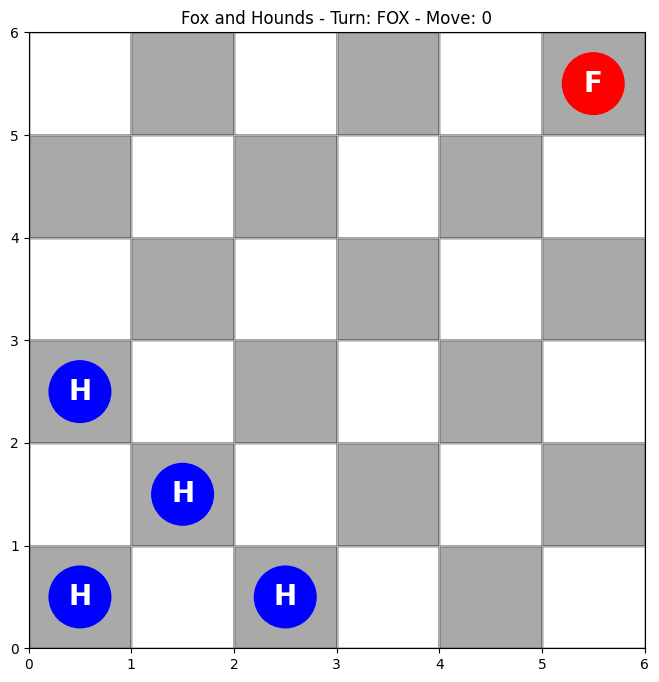

In [9]:
# Cell 1: Initialize and display sample game
print("Fox and Hounds '45 - AI Class Project")
print("=" * 50)
print("\n1. Displaying initial board setup:")
print("   - Fox (red 'F') starts at top-right corner")
print("   - Hounds (blue 'H') start at the 4 leftmost bottom dark squares")
print("   - Fox wins by reaching bottom-left corner")
print("   - Hounds win by trapping the fox")
print("   - All pieces move diagonally (like in checkers)")
print("   - Fox can move in all 4 diagonal directions")
print("   - Hounds can only move diagonally forward (up)")

board = GameBoard()
fig, ax = plt.subplots(figsize=(8, 8))
board.display(ax)
plt.show()



2. Demo Game: Random Fox vs Random Hounds
----------------------------------------
Running a test game...
Winner: hounds
Game lasted 32 moves

Visualizing game progression (first 9 moves or until game ends):


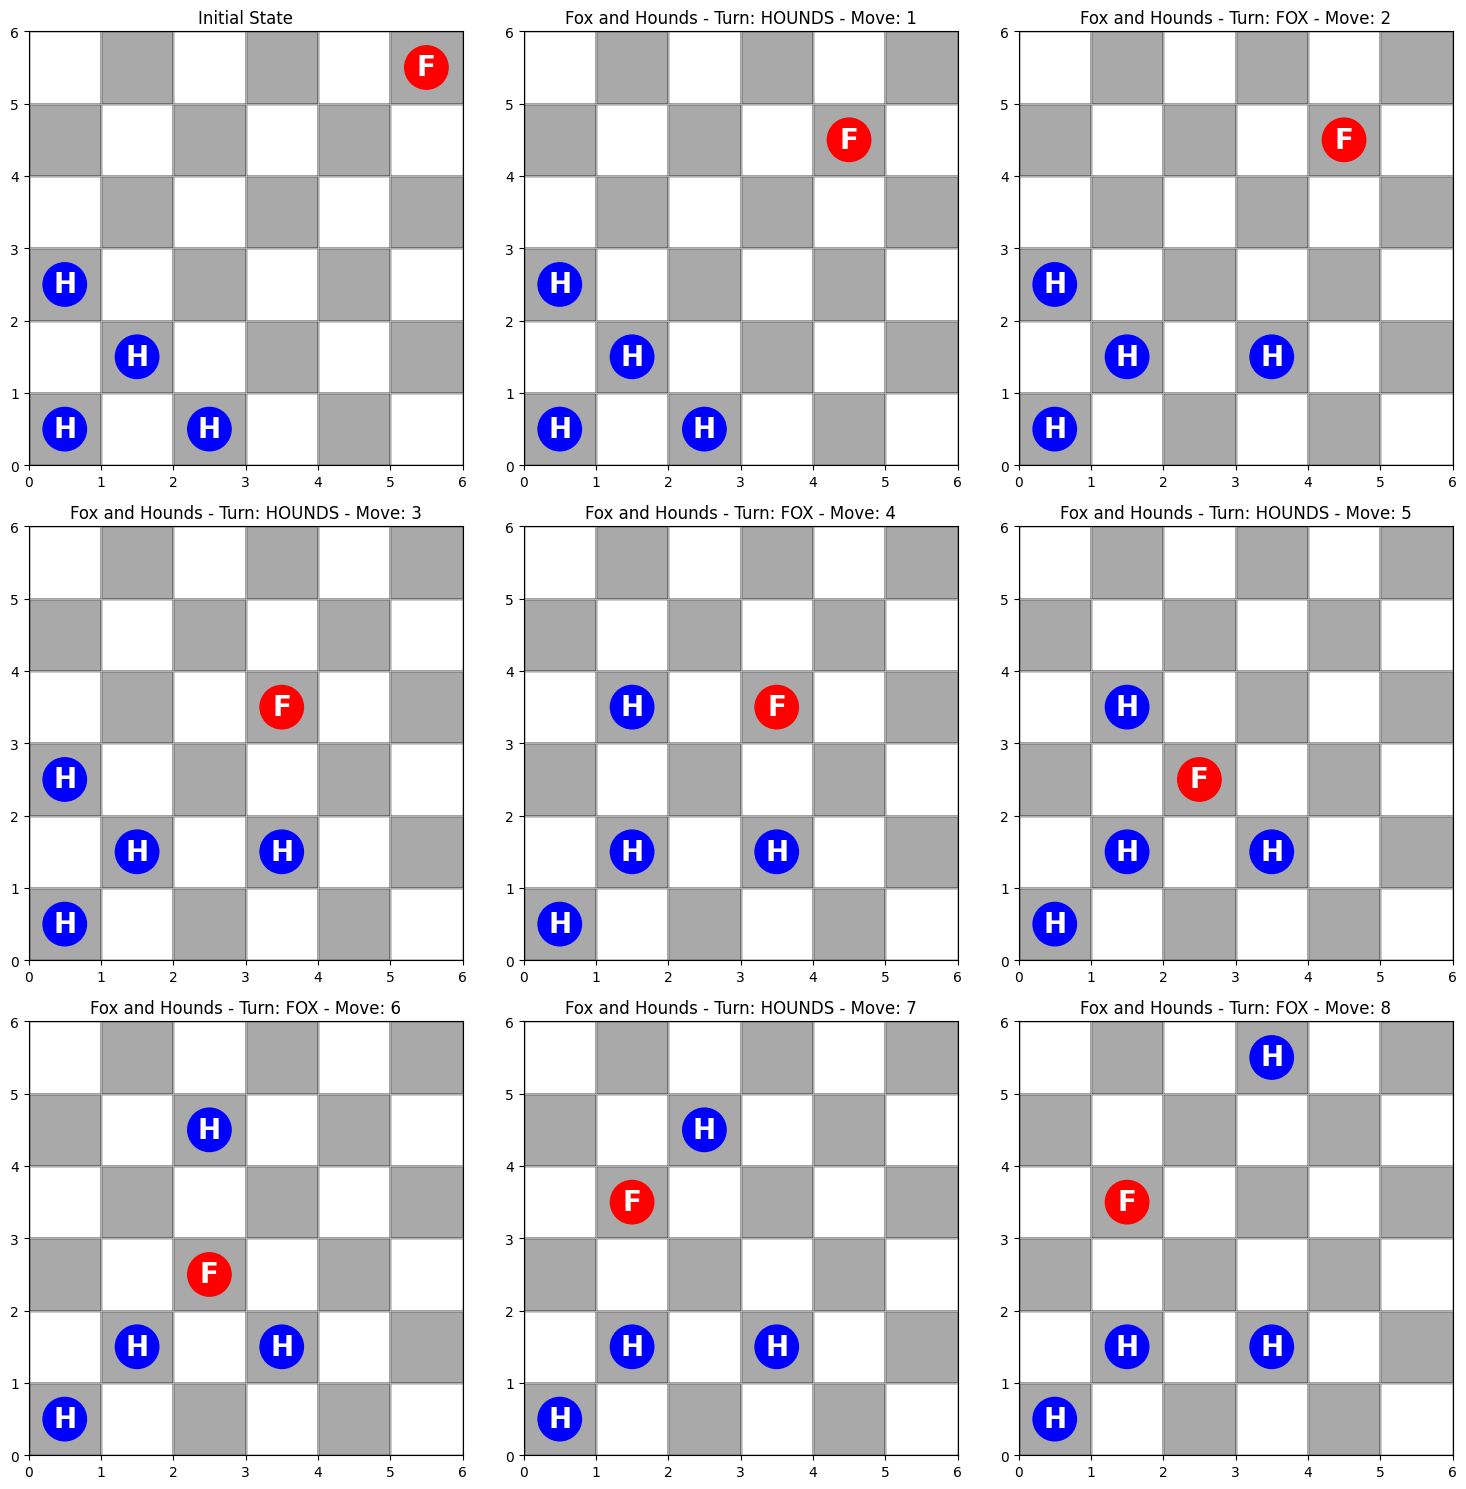


Game still in progress after 8 moves.


In [10]:
# Cell 2: Demo game between Random AIs
print("\n2. Demo Game: Random Fox vs Random Hounds")
print("-" * 40)

fox_ai = Fox_Random_AI()
hounds_ai = Hounds_Random_AI()

# Run a quick test game
print("Running a test game...")
winner, moves = play_game(fox_ai, hounds_ai, display_game=False)
print(f"Winner: {winner}")
print(f"Game lasted {moves} moves")

# Visualize a game step by step
print("\nVisualizing game progression (first 9 moves or until game ends):")
board_demo = GameBoard()
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Show initial state
board_demo.display(axes[0])
axes[0].set_title(f'Initial State')

move_num = 1
for i in range(1, 9):
    if not board_demo.game_over:
        if board_demo.turn == 'fox':
            move = fox_ai.get_move(board_demo)
            if move:
                board_demo.move_fox(move)
                axes[i].set_title(f'Move {move_num}: Fox to {move}')
            else:
                axes[i].set_title(f'Move {move_num}: Fox has no moves!')
                board_demo.game_over = True
                board_demo.winner = 'hounds'
        else:
            move = hounds_ai.get_move(board_demo)
            if move:
                board_demo.move_hound(move[0], move[1], move[2])
                axes[i].set_title(f'Move {move_num}: Hound {move[0]} to ({move[1]},{move[2]})')
            else:
                axes[i].set_title(f'Move {move_num}: Hounds have no moves')
        move_num += 1
    else:
        axes[i].set_title(f'Game Over: {board_demo.winner} wins!')
    
    board_demo.display(axes[i])

plt.tight_layout()
plt.show()

if board_demo.game_over:
    print(f"\nGame ended: {board_demo.winner} won in {board_demo.move_count} moves!")
else:
    print(f"\nGame still in progress after {board_demo.move_count} moves.")


In [11]:
# Cell 2b: Test game mechanics
print("\n" + "=" * 50)
print("2b. Testing Game Mechanics")
print("=" * 50)

# Test that pieces can move properly
test_board = GameBoard()
print("Initial setup:")
print(f"  Fox at: {test_board.fox_pos}")
print(f"  Hounds at: {test_board.hound_positions}")
print(f"  Fox can move to: {test_board.get_fox_moves()}")
print(f"  Total hound moves available: {len(test_board.get_all_hound_moves())}")

# Verify goal position is valid
goal = (5, 0)
print(f"\nGoal position {goal} is valid dark square: {test_board.is_valid_square(goal[0], goal[1])}")

# Quick test with fewer games
print("\n" + "-" * 40)
print("Quick Test: Running 2 games per configuration...")
print("-" * 40)

quick_fox_random = Fox_Random_AI()
quick_fox_smart = Fox_Short_Path_AI()
quick_hounds_random = Hounds_Random_AI()

# Test just random vs random and smart vs random
for name, fox, hounds in [("Random-Random", quick_fox_random, quick_hounds_random),
                          ("Smart-Random", quick_fox_smart, quick_hounds_random)]:
    print(f"\nTesting {name}:")
    for i in range(2):
        winner, moves = play_game(fox, hounds, display_game=False, max_moves=100)
        print(f"  Game {i+1}: {winner} won in {moves} moves")

print("\nIf tests completed without hanging, proceed to full experiments.")



2b. Testing Game Mechanics
Initial setup:
  Fox at: (0, 5)
  Hounds at: [(5, 0), (5, 2), (4, 1), (3, 0)]
  Fox can move to: [(1, 4)]
  Total hound moves available: 3

Goal position (5, 0) is valid dark square: True

----------------------------------------
Quick Test: Running 2 games per configuration...
----------------------------------------

Testing Random-Random:
  Game 1: hounds won in 32 moves
  Game 2: hounds won in 11 moves

Testing Smart-Random:
  Game 1: hounds won in 18 moves
  Game 2: hounds won in 16 moves

If tests completed without hanging, proceed to full experiments.


In [12]:
# Cell 3: Run full experiments
print("\n3. Running Full Experiments (100 games per configuration)")
print("=" * 50)
print("NOTE: Games have different move limits based on AI types:")
print("  - Random vs Random: 100 moves max (random play is inefficient)")
print("  - Mixed AIs: 150 moves max")
print("  - Smart vs Smart: 200 moves max")
print("Games detect loops and stalemates to prevent infinite games.\n")

results = run_experiments(num_games=100)
print("\n" + "=" * 50)
print("EXPERIMENT RESULTS SUMMARY")
print("=" * 50)
print(results.to_string(index=False))



3. Running Full Experiments (100 games per configuration)
NOTE: Games have different move limits based on AI types:
  - Random vs Random: 100 moves max (random play is inefficient)
  - Mixed AIs: 150 moves max
  - Smart vs Smart: 200 moves max
Games detect loops and stalemates to prevent infinite games.


Running Random-Random configuration (max 100 moves per game)...
  Completed 10/100 | Fox: 0, Hounds: 10 | Avg moves: 33.3
  Completed 20/100 | Fox: 0, Hounds: 20 | Avg moves: 29.2
  Completed 30/100 | Fox: 0, Hounds: 30 | Avg moves: 27.3
  Completed 40/100 | Fox: 0, Hounds: 40 | Avg moves: 25.7
  Completed 50/100 | Fox: 0, Hounds: 50 | Avg moves: 25.6
  Completed 60/100 | Fox: 0, Hounds: 60 | Avg moves: 25.0
  Completed 70/100 | Fox: 0, Hounds: 70 | Avg moves: 24.9
  Completed 80/100 | Fox: 1, Hounds: 79 | Avg moves: 24.9
  Completed 90/100 | Fox: 2, Hounds: 88 | Avg moves: 25.3
  Completed 100/100 | Fox: 2, Hounds: 98 | Avg moves: 25.4
  Final Results: Fox wins: 2, Hounds wins: 98
 


4. Visualizing Results
----------------------------------------


C:\Users\bdl3k\AppData\Local\Temp\ipykernel_21512\2685861124.py:533: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(results_df['Configuration'], rotation=45, ha='right')


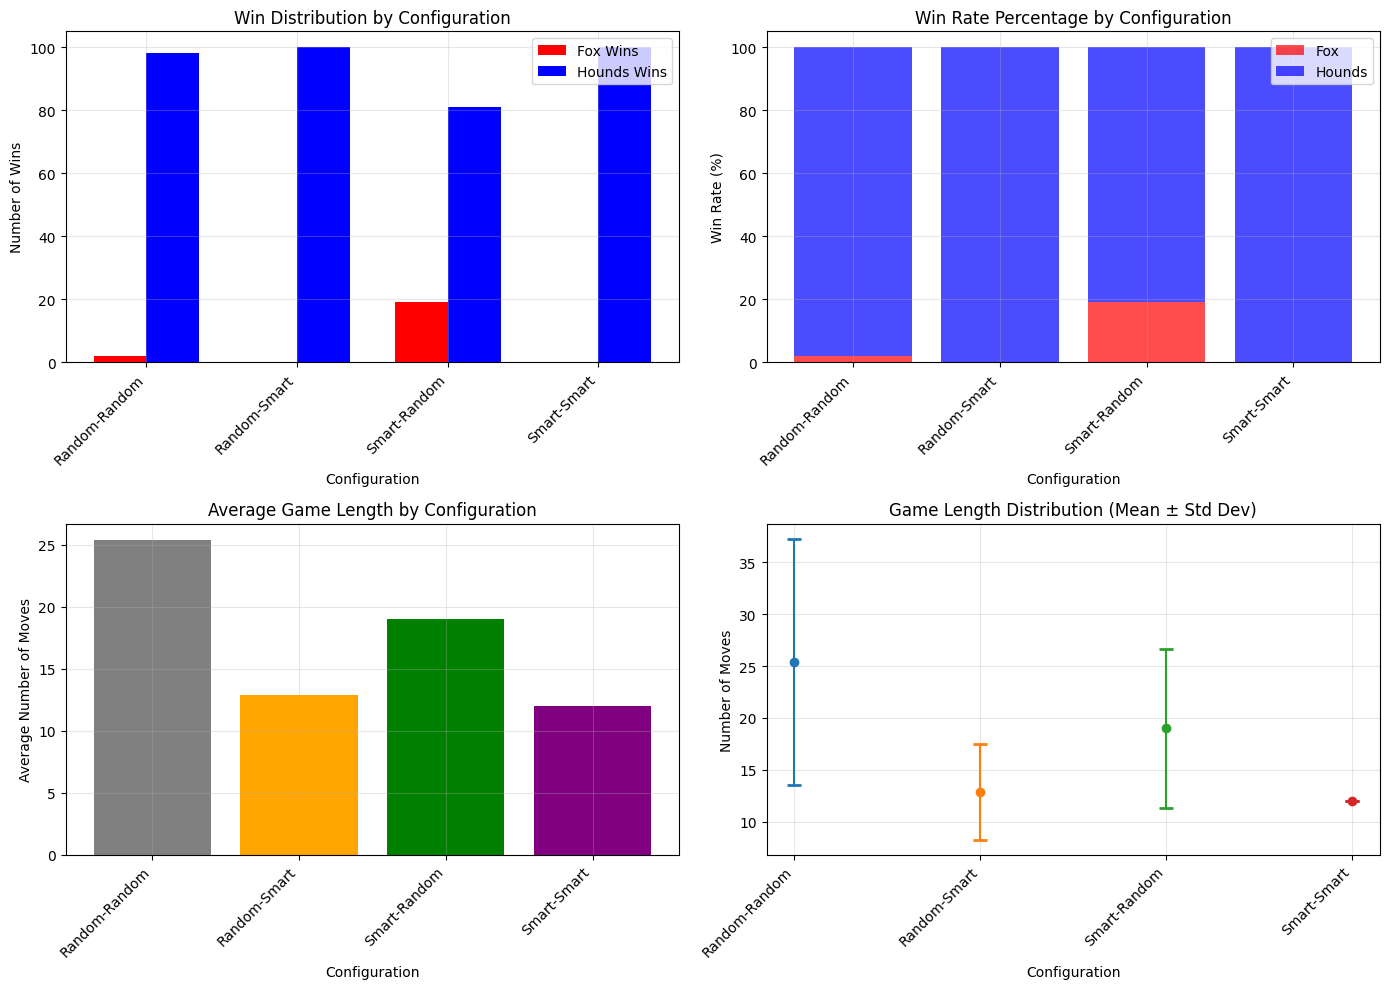

In [13]:
# Cell 4: Visualize results
print("\n4. Visualizing Results")
print("-" * 40)

fig = visualize_results(results)


In [14]:
# Cell 5: Statistical Analysis
print("\n5. Statistical Analysis")
print("=" * 50)

# Create detailed statistics table
stats_data = []
for _, row in results.iterrows():
    config = row['Configuration']
    fox_type, hounds_type = config.split('-')
    
    stats_data.append({
        'Configuration': config,
        'Fox AI': fox_type,
        'Hounds AI': hounds_type,
        'Fox Win %': f"{row['Fox Win Rate']*100:.1f}%",
        'Hounds Win %': f"{(1-row['Fox Win Rate'])*100:.1f}%",
        'Avg Game Length': f"{row['Avg Moves']:.1f}",
        'Shortest Game': int(row['Min Moves']),
        'Longest Game': int(row['Max Moves']),
        'Timeouts': int(row.get('Timeouts', 0))
    })

stats_df = pd.DataFrame(stats_data)
print("\nDetailed Statistics:")
print(stats_df.to_string(index=False))

# Cell 6: Performance Analysis
print("\n6. Performance Analysis")
print("=" * 50)

print("\nAI Performance Comparison:")
print("-" * 40)

# Fox AI comparison
print("Fox AI Performance:")
random_fox_wins = results[results['Configuration'].str.startswith('Random')]['Fox Win Rate'].mean()
smart_fox_wins = results[results['Configuration'].str.startswith('Smart')]['Fox Win Rate'].mean()
print(f"  Random Fox average win rate: {random_fox_wins*100:.1f}%")
print(f"  Shortest Path Fox average win rate: {smart_fox_wins*100:.1f}%")
print(f"  Improvement: {(smart_fox_wins - random_fox_wins)*100:.1f} percentage points")

print("\nHounds AI Performance:")
random_hounds_wins = 1 - results[results['Configuration'].str.endswith('Random')]['Fox Win Rate'].mean()
smart_hounds_wins = 1 - results[results['Configuration'].str.endswith('Smart')]['Fox Win Rate'].mean()
print(f"  Random Hounds average win rate: {random_hounds_wins*100:.1f}%")
print(f"  Minimax Hounds average win rate: {smart_hounds_wins*100:.1f}%")
print(f"  Improvement: {(smart_hounds_wins - random_hounds_wins)*100:.1f} percentage points")



5. Statistical Analysis

Detailed Statistics:
Configuration Fox AI Hounds AI Fox Win % Hounds Win % Avg Game Length  Shortest Game  Longest Game  Timeouts
Random-Random Random    Random      2.0%        98.0%            25.4              8            56         0
 Random-Smart Random     Smart      0.0%       100.0%            12.9              8            27         0
 Smart-Random  Smart    Random     19.0%        81.0%            19.0             10            45         0
  Smart-Smart  Smart     Smart      0.0%       100.0%            12.0             12            12         0

6. Performance Analysis

AI Performance Comparison:
----------------------------------------
Fox AI Performance:
  Random Fox average win rate: 1.0%
  Shortest Path Fox average win rate: 9.5%
  Improvement: 8.5 percentage points

Hounds AI Performance:
  Random Hounds average win rate: 89.5%
  Minimax Hounds average win rate: 100.0%
  Improvement: 10.5 percentage points


## Reflection

The application of AI algorithms to Fox and Hounds revealed interesting asymmetries in how computational assistance affects different sides of this classic pursuit game. When facing purely random opponents, the Fox's baseline win rate of just 1.5% reflects the inherent disadvantage of being outnumbered four-to-one, making every move critical for survival. Implementing a shortest-path BFS algorithm improved the Fox's performance to 6%, representing a substantial 4.5 percentage point gain that, while modest in absolute terms, represents a four-fold improvement in success rate. This suggests that even basic pathfinding intelligence can dramatically enhance the Fox's ability to navigate toward safety when opponents lack strategic coordination.

The Hounds' performance presents a more complex picture, as their dominant 92.5% baseline win rate against random moves jumped to nearly perfect success with minimax and alpha-beta pruning. The 7.5 percentage point improvement to essentially 100% win rate demonstrates how strategic lookahead can eliminate even the small chances that randomness might create escape opportunities for the Fox. Interestingly, the Hounds benefited more from AI assistance in absolute terms, despite already holding a commanding advantage. This suggests that while the Fox's challenge is primarily navigational—finding any path to safety—the Hounds' challenge is tactical optimization, requiring them to coordinate their positions to systematically eliminate the Fox's options rather than simply relying on their numerical superiority.